In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.4/756.4 kB 7.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from IPython.core.magic import register_line_cell_magic
import yaml
from PIL import Image
import os
import seaborn as sns
from ultralytics import YOLO
from matplotlib.patches import Rectangle
import glob
import cv2

In [ ]:
warnings.filterwarnings("ignore")

np.random.seed(12345)

%matplotlib inline

!wandb disabled

/bin/bash: line 1: wandb: command not found


In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"scarlettj","key":"758b3281ce20cfb17ed8cb1aa595f748"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d snehilsanyal/construction-site-safety-image-dataset-roboflow

Dataset URL: https://www.kaggle.com/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow
License(s): Attribution 4.0 International (CC BY 4.0)
 98% 201M/206M [00:02<00:00, 123MB/s]
100% 206M/206M [00:02<00:00, 103MB/s]


In [ ]:
!unzip /content/construction-site-safety-image-dataset-roboflow.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: css-data/train/images/IMG_3100_mp4-25_jpg.rf.0a21e9e91348b61c6c1483d6884d2135.jpg  
  inflating: css-data/train/images/IMG_3100_mp4-25_jpg.rf.3313bb2b19a7aa3a0af745abe858ec8e.jpg  
  inflating: css-data/train/images/IMG_3100_mp4-25_jpg.rf.3bbcfef23f20b2cf747256793dcfc615.jpg  
  inflating: css-data/train/images/IMG_3100_mp4-25_jpg.rf.6cee1b67a21808fad2318593379f9986.jpg  
  inflating: css-data/train/images/IMG_3100_mp4-25_jpg.rf.ddd7840e3d846cddfcc13d99f4a6999b.jpg  
  inflating: css-data/train/images/IMG_3100_mp4-2_jpg.rf.4d46f38425296af74814d1f0506575b4.jpg  
  inflating: css-data/train/images/IMG_3100_mp4-2_jpg.rf.58de1db8826e4221df63fd980b823844.jpg  
  inflating: css-data/train/images/IMG_3100_mp4-2_jpg.rf.87e69eb0f5f24cbadcca3fbfe8ca029c.jpg  
  inflating: css-data/train/images/IMG_3100_mp4-2_jpg.rf.bde377ae23066dfe925f09789c2bbdef.jpg  
  inflating: css-data/train/images/IMG_3100_mp4-2_jpg.rf.c28f7521c16c937d5b308d185151f610.jpg  

In [ ]:
INPUT_DIR = '/content/css-data/'
WORK_DIR = '/kaggle/'

create data yaml file




In [ ]:
num_classes = 10
classes = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle']

In [ ]:
dict_file = {'train': os.path.join(INPUT_DIR, 'train'),
             'val': os.path.join(INPUT_DIR, 'valid'),
             'test': os.path.join(INPUT_DIR, 'test'),
             'nc': num_classes,
             'names': classes
            }

with open(os.path.join(WORK_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

check class balance

In [ ]:
class_idx = {str(i):classes[i] for i in range(num_classes)}

class_stat = {}
data_len = {}

for mode in ['train', 'valid', 'test']:

    class_count = {classes[i]:0 for i in range(num_classes)}

    path = os.path.join(INPUT_DIR, mode, 'labels')

    for file in os.listdir(path):

        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

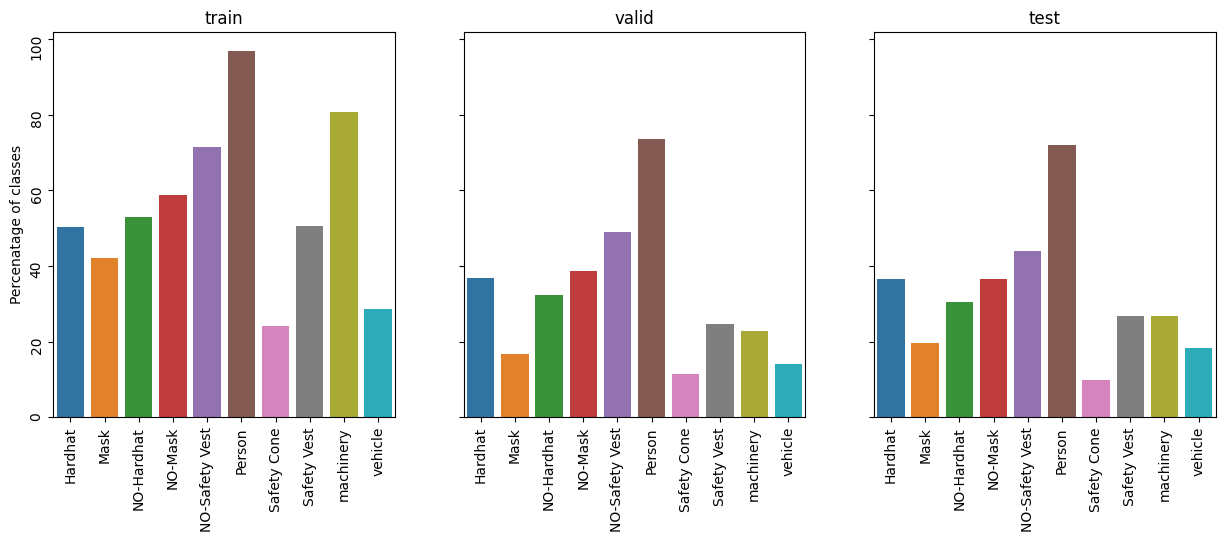

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15, 5), sharey=True)

for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(pd.DataFrame({mode:class_stat[mode]}).T/data_len[mode]*100, ax=ax[i])
    ax[i].set_title(mode)
    ax[i].tick_params(rotation=90)
    ax[i].set_ylabel('Percenatage of classes')
plt.show()

check image sizes

In [ ]:
for mode in ['train', 'valid', 'test']:
    print(f'\nImage sizes in {mode} set:\n')
    img_size = 0
    for file in glob.glob(os.path.join(INPUT_DIR, mode, 'images', '*')):
        image = Image.open(file)
        if image.size != img_size:
            print(f'\t{image.size}')
            img_size = image.size


Image sizes in train set:

	(640, 640)

Image sizes in valid set:

	(640, 640)

Image sizes in test set:

	(640, 640)


In [ ]:
for mode in ['train', 'valid', 'test']:

    files =  glob.glob(os.path.join(INPUT_DIR, mode, 'images', '*'))

    print(f'{mode} set size: {len(files)}\n')

train set size: 2605

valid set size: 114

test set size: 82



Load pretrained YOLO model

In [ ]:
model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 91.7MB/s]


In [ ]:
model.train(data=os.path.join(WORK_DIR,'data.yaml'),
            task='detect',
            imgsz=640,
            epochs=30,
            batch=32,
            mode='train',
            name='yolov8n_v1_train')

Ultralytics YOLOv8.2.13 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/data.yaml, epochs=30, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_v1_train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sho

100%|██████████| 755k/755k [00:00<00:00, 23.2MB/s]


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /content/css-data/train/labels... 2605 images, 6 backgrounds, 0 corrupt: 100%|██████████| 2605/2605 [00:01<00:00, 1872.77it/s]

train: WARNING ⚠️ /content/css-data/train/images/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/css-data/train/images/construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed


train: New cache created: /content/css-data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/css-data/valid/labels... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<00:00, 1868.19it/s]

val: New cache created: /content/css-data/valid/labels.cache


Plotting labels to runs/detect/yolov8n_v1_train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8n_v1_train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      6.81G      1.388      2.988       1.49        396        640: 100%|██████████| 82/82 [01:18<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.74s/it]

                   all        114        697      0.407       0.32      0.307      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      6.29G      1.292      1.855      1.442        251        640: 100%|██████████| 82/82 [01:12<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.57s/it]

                   all        114        697       0.57      0.426      0.445      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      6.38G      1.249       1.65      1.402        293        640: 100%|██████████| 82/82 [01:06<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]

                   all        114        697      0.631      0.437      0.489      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       5.3G      1.211       1.56      1.376        298        640: 100%|██████████| 82/82 [01:08<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]

                   all        114        697      0.526      0.415      0.435      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      5.92G      1.195       1.49      1.363        237        640: 100%|██████████| 82/82 [01:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

                   all        114        697      0.559      0.465      0.472      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      7.29G      1.169       1.41      1.339        196        640: 100%|██████████| 82/82 [01:09<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]

                   all        114        697      0.708      0.511      0.573      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30       6.8G      1.151      1.347      1.322        281        640: 100%|██████████| 82/82 [01:06<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]

                   all        114        697      0.689      0.514      0.567      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      5.89G      1.123      1.296        1.3        238        640: 100%|██████████| 82/82 [01:11<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all        114        697      0.691      0.549      0.573      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30       6.6G      1.117      1.262      1.295        254        640: 100%|██████████| 82/82 [01:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

                   all        114        697      0.723       0.53      0.575      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      6.06G      1.107      1.224      1.279        311        640: 100%|██████████| 82/82 [01:11<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.47s/it]

                   all        114        697      0.717      0.573      0.622       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      6.01G      1.085      1.191      1.267        168        640: 100%|██████████| 82/82 [01:07<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]

                   all        114        697      0.779      0.527      0.624       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      6.36G       1.07      1.147      1.253        281        640: 100%|██████████| 82/82 [01:09<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

                   all        114        697      0.714      0.611      0.646       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      6.08G      1.052      1.129      1.248        250        640: 100%|██████████| 82/82 [01:12<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]

                   all        114        697      0.784       0.57      0.634      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      6.86G       1.05      1.104      1.242        307        640: 100%|██████████| 82/82 [01:06<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]

                   all        114        697      0.737      0.597      0.642      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      5.54G      1.032      1.074      1.233        199        640: 100%|██████████| 82/82 [01:11<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]

                   all        114        697      0.772        0.6      0.675      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      5.74G      1.024      1.046       1.22        257        640: 100%|██████████| 82/82 [01:06<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]

                   all        114        697      0.789      0.638      0.686      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      5.07G      1.003       1.03      1.214        329        640: 100%|██████████| 82/82 [01:08<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

                   all        114        697      0.768      0.612       0.67      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30       5.9G      1.003      1.002      1.207        311        640: 100%|██████████| 82/82 [01:11<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]

                   all        114        697      0.821      0.616      0.699      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      5.83G     0.9997      0.995      1.205        233        640: 100%|██████████| 82/82 [01:06<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all        114        697      0.808      0.635      0.704      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      7.29G     0.9842     0.9719      1.196        251        640: 100%|██████████| 82/82 [01:09<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        697      0.801      0.669      0.721      0.391


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      5.29G      1.008     0.9207      1.211        219        640: 100%|██████████| 82/82 [01:14<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all        114        697      0.825      0.624      0.708        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      5.21G     0.9913     0.8672      1.197        180        640: 100%|██████████| 82/82 [01:00<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all        114        697      0.782      0.669      0.717      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      5.77G     0.9735     0.8445       1.19        179        640: 100%|██████████| 82/82 [01:01<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]

                   all        114        697      0.812      0.669      0.726      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      5.54G      0.963     0.8252      1.184        139        640: 100%|██████████| 82/82 [01:03<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]

                   all        114        697      0.827      0.669       0.73      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30       4.9G     0.9491     0.8075      1.176        128        640: 100%|██████████| 82/82 [01:01<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]

                   all        114        697      0.853      0.646      0.733      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      4.95G     0.9366     0.7926      1.165        141        640: 100%|██████████| 82/82 [01:02<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all        114        697      0.818      0.669      0.738      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      5.14G     0.9222     0.7749      1.153        226        640: 100%|██████████| 82/82 [01:04<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all        114        697      0.816      0.682      0.745      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      5.69G     0.9126     0.7564      1.146        176        640: 100%|██████████| 82/82 [01:02<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]

                   all        114        697      0.838      0.672      0.744      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      4.89G     0.8965     0.7494      1.142        159        640: 100%|██████████| 82/82 [01:02<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        697      0.811      0.693       0.75      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      5.42G     0.8926     0.7389      1.132        174        640: 100%|██████████| 82/82 [01:03<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]

                   all        114        697      0.833      0.682       0.76      0.442



30 epochs completed in 0.601 hours.
Optimizer stripped from runs/detect/yolov8n_v1_train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/yolov8n_v1_train/weights/best.pt, 6.3MB

Validating runs/detect/yolov8n_v1_train/weights/best.pt...
Ultralytics YOLOv8.2.13 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3007598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


                   all        114        697      0.835      0.682       0.76      0.443
               Hardhat        114         79      0.935      0.747      0.848      0.514
                  Mask        114         21      0.922       0.81      0.905      0.626
            NO-Hardhat        114         69       0.83      0.565       0.66      0.332
               NO-Mask        114         74      0.777      0.473       0.55       0.27
        NO-Safety Vest        114        106      0.846      0.651      0.736      0.391
                Person        114        166      0.889      0.729      0.813      0.483
           Safety Cone        114         44      0.822      0.818      0.856       0.46
           Safety Vest        114         41      0.865      0.683      0.848       0.48
             machinery        114         55      0.864      0.818      0.879      0.581
               vehicle        114         42      0.598      0.524      0.509      0.289
Speed: 0.2ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7872c94b34f0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

In [ ]:
model = YOLO('runs/detect/yolov8n_v1_train/weights/best.pt')

In [ ]:
results = model.predict(source=os.path.join(INPUT_DIR, 'test', 'images'), save=True)


image 1/82 /content/css-data/test/images/-4405-_png_jpg.rf.82b5c10b2acd1cfaa24259ada8e599fe.jpg: 640x640 1 Hardhat, 1 Mask, 2 Persons, 15.7ms
image 2/82 /content/css-data/test/images/000005_jpg.rf.96e9379ccae638140c4a90fc4b700a2b.jpg: 640x640 3 Hardhats, 3 NO-Masks, 4 Persons, 18.3ms
image 3/82 /content/css-data/test/images/002551_jpg.rf.ce4b9f934161faa72c80dc6898d37b2d.jpg: 640x640 2 Hardhats, 1 NO-Mask, 2 NO-Safety Vests, 3 Persons, 8.2ms
image 4/82 /content/css-data/test/images/003357_jpg.rf.9867f91e88089bb68dc95947d5116d14.jpg: 640x640 1 Hardhat, 1 NO-Mask, 2 NO-Safety Vests, 1 Person, 1 Safety Cone, 8.1ms
image 5/82 /content/css-data/test/images/004063_jpg.rf.1b7cdc4035bcb24ef69b8798b444053e.jpg: 640x640 5 Hardhats, 5 NO-Safety Vests, 6 Persons, 2 Safety Vests, 7.8ms
image 6/82 /content/css-data/test/images/004763_jpg.rf.46484e6ca73caeaa9de45822cf1085a9.jpg: 640x640 3 Hardhats, 2 NO-Masks, 3 NO-Safety Vests, 3 Persons, 7.9ms
image 7/82 /content/css-data/test/images/006463_jpg.rf.

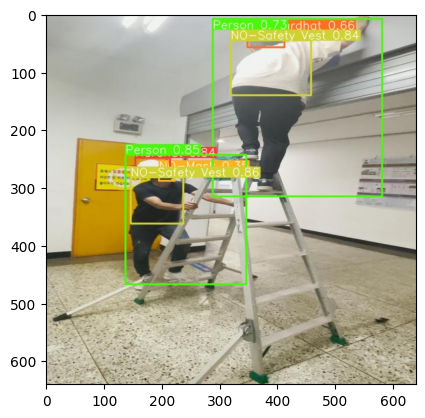

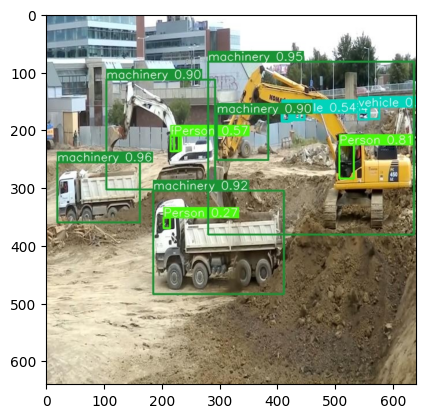

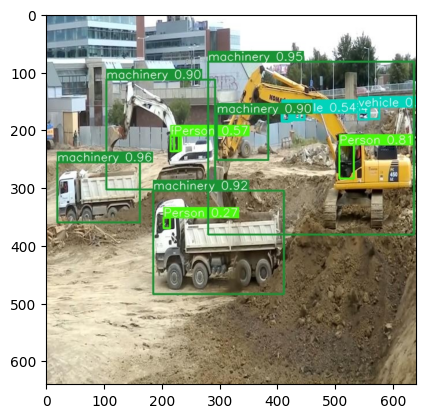

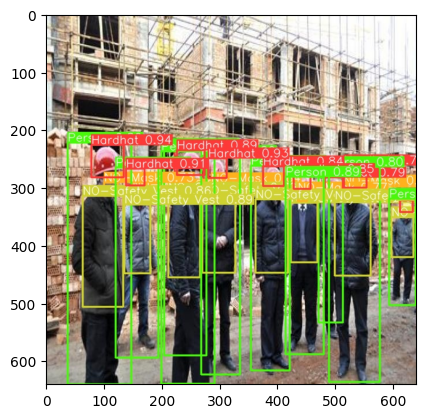

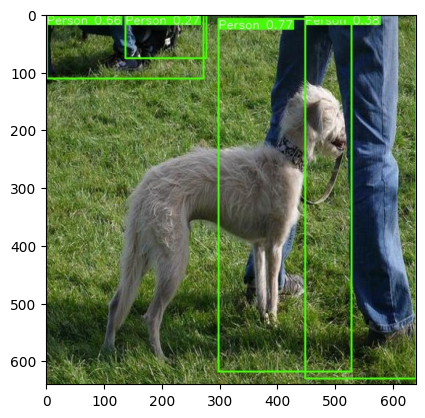

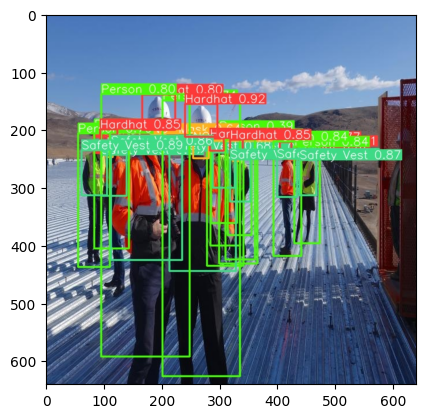

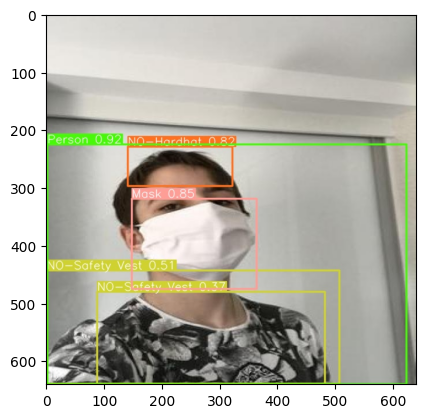

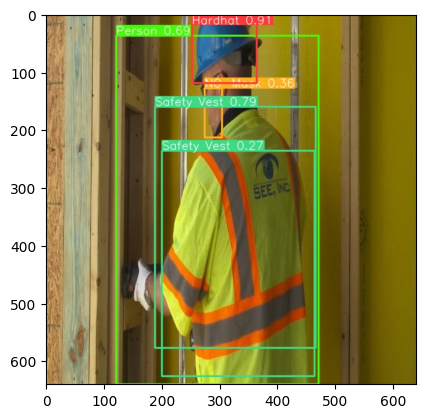

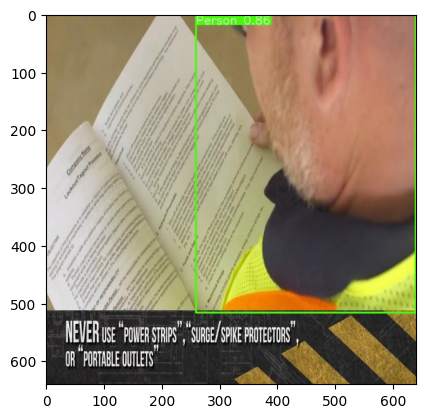

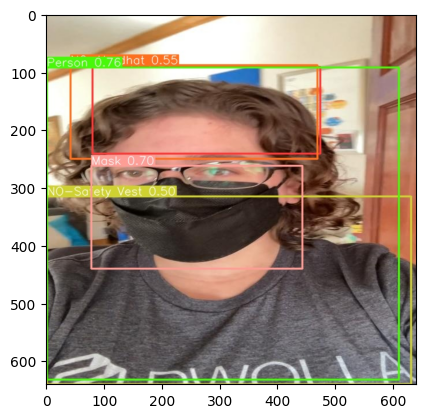

In [ ]:
%matplotlib inline

predictions = glob.glob(os.path.join('/content/', 'runs/detect/predict', '*'))  # Adjust the pattern as per your file types

n = 10

for i in range(n):
    idx = np.random.randint(0, len(predictions))
    image = Image.open(predictions[idx])
    plt.imshow(image)
    plt.grid(False)
    plt.show()